# Course: Modern Methods of Data Analysis.

## Homework 1. Topic: Basic classification techniques. Quality metric and cross-validation.

***Author: Ivan Zaputliaev (former TA)***  

---

**Lecturer:** Dmitry Ignatov [dmitrii.ignatov@gmail.com](dmitrii.ignatov@gmail.com)

**TA:** Airat Valiev [aa.valiev@hse.ru](aa.valiev@hse.ru) & Denis Pozdnyakov [dvpozdnyakov@hse.ru](dvpozdnyakov@hse.ru)

**Q&A:** course chat ([link](https://t.me/+83U7KG9fqSdjYjgy)) or via TA's e-mail

|

**Soft deadline** (up to 10 points): <span style="color:red">***April 12***</span>   
**Hard deadline** (-2 points):  <span style="color:blue">***April 15***</span>    


---




Please send your final notebooks to both teaching assistants (and lecturer in CC) with the **mandatory topic** ***[MMDA2025-HW1-Classification-your_full_name]***.

*The dataset source: UCI ML repository (https://archive.ics.uci.edu/ml/datasets)*


In [1]:
import sys

sys.version

'3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'

In [2]:
# noinspection PyUnusedLocal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# extended methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

sns.set_style('whitegrid')
%matplotlib inline

## Binary classification

### Load data

In [3]:
train = pd.read_csv('spambase_train.csv', sep=',')
test = pd.read_csv('spambase_test.csv', sep=',')
target = 'is_spam'

x_dev, y_dev = train.drop(target, axis=1), train[target]
x_test, y_test = test.drop(target, axis=1), test[target]

train.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.337,0.000,0.000,0.000,0.337,2.950,7,59,0
1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,4,0
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.265,0.000,0.000,0.000,1.650,12,33,0
3,0.00,0.00,0.00,0.0,0.00,0.00,1.07,0.00,0.00,0.00,...,0.000,0.000,0.000,0.145,0.437,0.291,1.823,10,62,1
4,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.114,0.114,0.000,0.114,1.645,12,51,0
5,0.00,0.00,0.00,0.0,0.00,0.00,1.78,0.00,0.00,0.00,...,0.000,0.000,0.000,0.586,0.000,0.000,1.307,4,17,0
6,0.51,0.43,0.29,0.0,0.14,0.03,0.00,0.18,0.54,0.62,...,0.012,0.078,0.000,0.443,0.510,0.133,6.590,739,2333,1
7,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.746,0.000,0.000,0.000,0.000,1.687,4,27,0
8,0.00,2.12,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,4.117,47,70,0
9,0.00,1.50,1.50,0.0,0.75,0.00,0.00,0.00,0.75,3.75,...,0.000,0.000,0.000,2.224,1.223,0.000,107.400,412,537,1


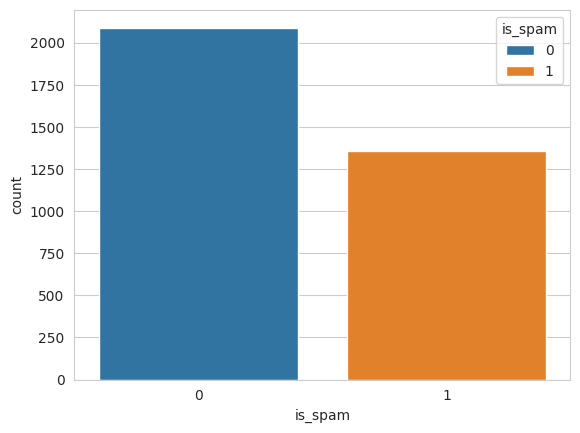

In [4]:
_ = sns.countplot(x=y_dev, hue=y_dev)

### Perform cross-validation to train Logistic Regression

Set cross-validation parameters

In [5]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

Set data scaling parameters

In [6]:
scaler = StandardScaler()

Set classifier parameters

In [7]:
clf_params = {'penalty': 'l2', 'C': 0.001}
clf = LogisticRegression(**clf_params, solver='lbfgs', n_jobs=8, random_state=1)

Perform cross-validation to calculate model's quality. Draw the ROC-curve to detect overfitting


fold 1 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.871014       0.965821  0.816495         0.925234      0.730627

fold 2 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.871014       0.947219  0.818737         0.917808      0.738971

fold 3 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.857971        0.94371  0.794979          0.92233      0.698529

fold 4 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.862319        0.94035   0.80167         0.927536      0.705882

fold 5 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.852174       0.938353  0.785714         0.916667        0.6875


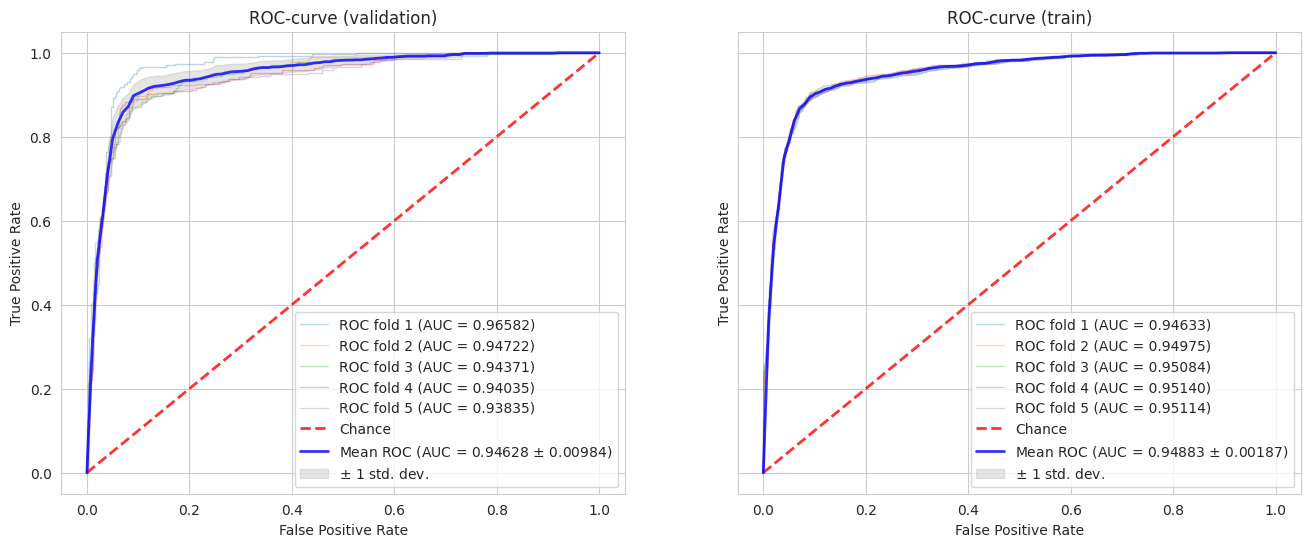

In [8]:
models = []

tprs = [[], []]
aucs = [[], []]
mean_fpr = np.linspace(0, 1, 100)
i = 1

fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 6)

for index_train, index_val in cv.split(X=x_dev, y=y_dev):
    # split data to train/validation
    x_train, y_train = x_dev.loc[index_train].values, y_dev.loc[index_train].values
    x_val, y_val = x_dev.loc[index_val].values, y_dev.loc[index_val].values

    # data scaling for metric classifiers
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    # train model
    model = clf.fit(x_train_scaled, y_train)
    models.append(model)  # save trained models

    # make prediction and calculate model's quality
    y_val_pred = model.predict(x_val_scaled)  # predicted labels
    y_val_pred_proba = model.predict_proba(x_val_scaled)[:, 1]  # predicted probability of being from class 1

    y_val_pred_quality = pd.DataFrame({'accuracy': accuracy_score(y_val, y_val_pred),
                                       'roc_auc_score': roc_auc_score(y_val, y_val_pred_proba),
                                       'f1_score': f1_score(y_val, y_val_pred),
                                       'precision_score': precision_score(y_val, y_val_pred),
                                       'recall_score': recall_score(y_val, y_val_pred)}, index=[0])
    print()
    print(f'fold {i:d} of {n_splits:d}:')
    print(y_val_pred_quality)

    # calculate ROC-AUC
    # validation
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
    tprs[0].append(np.interp(mean_fpr, fpr, tpr))
    tprs[0][-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs[0].append(roc_auc)
    _ = ax[0].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

    # train
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train_scaled)[:, 1])
    tprs[1].append(np.interp(mean_fpr, fpr, tpr))
    tprs[1][-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs[1].append(roc_auc)
    _ = ax[1].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

    i += 1

# plot ROC-curve
for i in range(2):
    _ = ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs[i], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs[i])
    _ = ax[i].plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:0.5f} $\pm$ {std_auc:0.5f})', lw=2,
                   alpha=.8)

    std_tpr = np.std(tprs[i], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = ax[i].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    _ = ax[i].set_xlim([-0.05, 1.05])
    _ = ax[i].set_ylim([-0.05, 1.05])
    _ = ax[i].set_xlabel('False Positive Rate')
    _ = ax[i].set_ylabel('True Positive Rate')
    _ = ax[i].legend(loc='lower right')

_ = ax[0].set_title('ROC-curve (validation)')
_ = ax[1].set_title('ROC-curve (train)')
plt.show()

Look at LR coefficients and analyse results

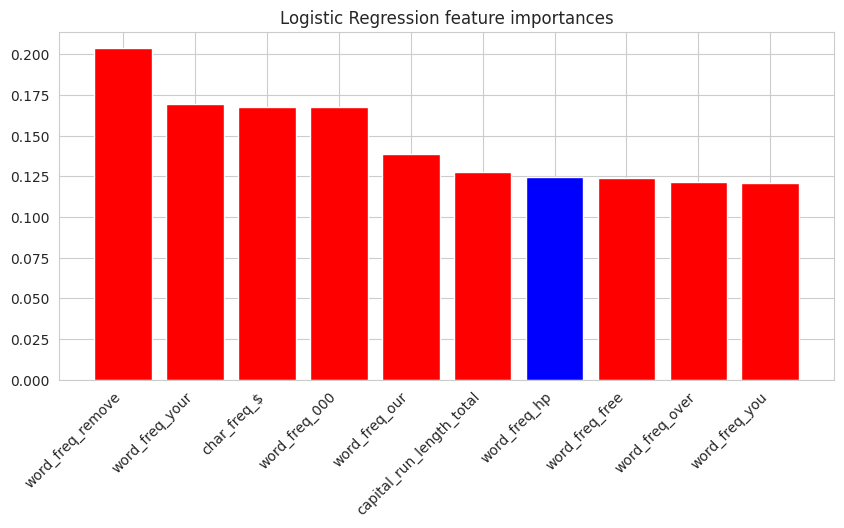

In [9]:
i = 0
lr_feature_importance = pd.DataFrame({'feature': x_dev.columns,
                                      'coeff': models[i].coef_[0], 'abs(coeff)': np.abs(models[i].coef_[0])})
lr_feature_importance.sort_values('abs(coeff)', ascending=False).head(10)

coefs = lr_feature_importance['coeff'].values
color = np.array(['red' if c > 0 else 'blue' for c in coefs])
coefs = np.abs(coefs)
indices = np.argsort(coefs)[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plt.title('Logistic Regression feature importances')
plt.bar(range(10), coefs[indices[:10]], color=color[indices[:10]], align='center')
plt.xticks(range(10), x_dev.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.show()

Plot probabilities distribution for the validation data from last CV iteration of being from "spam" class

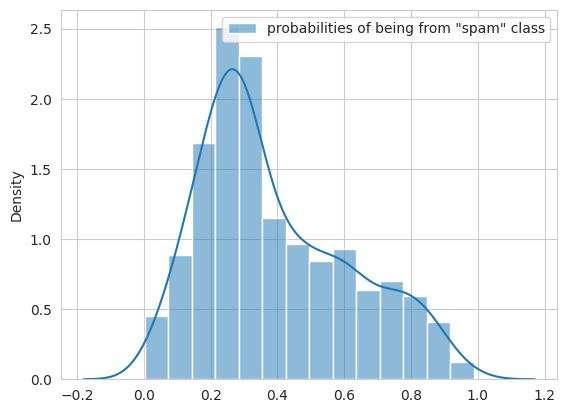

In [10]:
model = models[-1]
y_val_pred_proba = model.predict_proba(x_val_scaled)[:, 1]

_ = sns.histplot(y_val_pred_proba, kde=True, stat='density', kde_kws=dict(cut=3),
                 label='probabilities of being from "spam" class')
_ = plt.legend()
plt.show()

Show confusion matrix for LR prediction

Confusion matrix:
[[401  17]
 [ 85 187]]


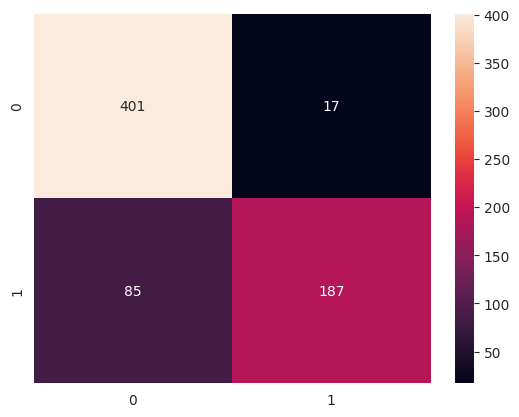

In [11]:
y_val_pred = model.predict(x_val_scaled)
print('Confusion matrix:')
confusion_matrix_df = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix_df)
_ = sns.heatmap(confusion_matrix_df, annot=True, fmt='.10g')

---
### Task 1 (3 points)

In [12]:
"""
Try 3 different values of n_splits and analyse overfitting and stability
Find n_splits values with maximum and minimum overfitting
Find n_splits values with maximum and minimum stability
"""
n_splits_candidates = [3, 5, 10]
results_overfitting = {}
results_stability = {}

print("Analyzing overfitting and stability for different n_splits values:")

# Loop through different values of n_splits
for ns in n_splits_candidates:
    cv_temp = StratifiedKFold(n_splits=ns, shuffle=True, random_state=1)
    train_auc_list = []
    val_auc_list = []
    # Perform cross-validation using the current number of splits
    for index_train, index_val in cv_temp.split(X=x_dev, y=y_dev):
        # Split the data into training and validation sets
        x_train = x_dev.loc[index_train].values
        y_train = y_dev.loc[index_train].values
        x_val   = x_dev.loc[index_val].values
        y_val   = y_dev.loc[index_val].values
        # Apply scaling with the predefined StandardScaler
        x_train_scaled = scaler.fit_transform(x_train)
        x_val_scaled   = scaler.transform(x_val)
        # Train the model with predefined Logistic Regression parameters
        model_temp = clf.fit(x_train_scaled, y_train)
        # Compute ROC-AUC for both training and validation sets
        auc_train = roc_auc_score(y_train, model_temp.predict_proba(x_train_scaled)[:, 1])
        auc_val   = roc_auc_score(y_val, model_temp.predict_proba(x_val_scaled)[:, 1])
        train_auc_list.append(auc_train)
        val_auc_list.append(auc_val)

    # Calculate average AUC values and derive overfitting measure
    mean_train_auc = np.mean(train_auc_list)
    mean_val_auc   = np.mean(val_auc_list)
    overfit_gap    = mean_train_auc - mean_val_auc
    std_val_auc    = np.std(val_auc_list)  # Standard deviation of validation AUC
    results_overfitting[ns] = overfit_gap
    results_stability[ns]  = std_val_auc

    print(f"n_splits = {ns}: mean_train_auc = {mean_train_auc:.5f}, mean_val_auc = {mean_val_auc:.5f}, "
          f"overfitting (gap) = {overfit_gap:.5f}, stability (std val AUC) = {std_val_auc:.5f}")

print("\nSummary:")
# For overfitting, we select:
ns_min_overfit = min(results_overfitting, key=results_overfitting.get)
ns_max_overfit = max(results_overfitting, key=results_overfitting.get)
# For stability, a lower standard deviation indicates higher stability.
ns_max_stability = min(results_stability, key=results_stability.get)
ns_min_stability = max(results_stability, key=results_stability.get)

print(f"n_splits with minimum overfitting (lowest train-val gap): {ns_min_overfit}")
print(f"n_splits with maximum overfitting (highest train-val gap): {ns_max_overfit}")
print(f"n_splits with maximum stability (lowest std of val AUC): {ns_max_stability}")
print(f"n_splits with minimum stability (highest std of val AUC): {ns_min_stability}")

Analyzing overfitting and stability for different n_splits values:
n_splits = 3: mean_train_auc = 0.94926, mean_val_auc = 0.94630, overfitting (gap) = 0.00296, stability (std val AUC) = 0.00803
n_splits = 5: mean_train_auc = 0.94989, mean_val_auc = 0.94709, overfitting (gap) = 0.00280, stability (std val AUC) = 0.00984
n_splits = 10: mean_train_auc = 0.95023, mean_val_auc = 0.94777, overfitting (gap) = 0.00246, stability (std val AUC) = 0.01147

Summary:
n_splits with minimum overfitting (lowest train-val gap): 10
n_splits with maximum overfitting (highest train-val gap): 3
n_splits with maximum stability (lowest std of val AUC): 3
n_splits with minimum stability (highest std of val AUC): 10


In [13]:
"""
Compare different values of Logistic Regression hyperparameters using cross-validation.
Try different values for: penalty, C, class_weight
Find the best parameters according to F1-score
"""
penalty = ['l1', 'l2']
C = [1.0, 10.0, 0.01, 0.0, 0.001]
class_weight = ['balanced', None]

# Define candidate hyperparameters
penalty_candidates = ['l1', 'l2']
C_candidates = [1.0, 10.0, 0.01, 0.001]
class_weight_candidates = ['balanced', None]
# Set up a pipeline: StandardScaler then LogisticRegression.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=1))
])
# Create param_grid for GridSearchCV with the candidates.
param_grid = {
    'clf__penalty': penalty_candidates,
    'clf__C': C_candidates,
    'clf__class_weight': class_weight_candidates
}
grid = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(x_dev, y_dev)

# Print the best hyperparameters and the corresponding best F1 score.
print("Best logistic regression hyperparameters according to F1 score:")
print("Best parameters:", grid.best_params_)
print("Best F1 Score: {:.5f}".format(grid.best_score_))

Best logistic regression hyperparameters according to F1 score:
Best parameters: {'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Best F1 Score: 0.90864


In [14]:
"""
Train a model with the best parameters on the whole training dataset.
Analyse overfitting using the test data. Is it lower or bigger, comparing to validation case?
"""
# Use the best estimator from the GridSearchCV
best_pipeline = grid.best_estimator_
best_pipeline.fit(x_dev, y_dev)

# Evaluate the model on the training dataset
y_dev_pred = best_pipeline.predict(x_dev)
y_dev_proba = best_pipeline.predict_proba(x_dev)[:, 1]
train_auc = roc_auc_score(y_dev, y_dev_proba)
train_f1 = f1_score(y_dev, y_dev_pred)

# Evaluate the model on the test dataset
y_test_pred = best_pipeline.predict(x_test)
y_test_proba = best_pipeline.predict_proba(x_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)

print("Performance on full training data:")
print(f"  Training AUC: {train_auc:.5f}")
print(f"  Training F1:  {train_f1:.5f}")

print("\nPerformance on test data:")
print(f"  Test AUC:     {test_auc:.5f}")
print(f"  Test F1:      {test_f1:.5f}")

overfit_gap_auc = train_auc - test_auc
overfit_gap_f1 = train_f1 - test_f1

print("\nOverfitting Analysis:")
print(f"  Train-Test AUC gap: {overfit_gap_auc:.5f}")
print(f"  Train-Test F1 gap:  {overfit_gap_f1:.5f}")

# A note on interpretation: A larger gap between training and test performance generally indicates
# that the model might be overfitting (performing substantially better on the training data).
if overfit_gap_auc > 0 or overfit_gap_f1 > 0:
    print("The model shows some overfitting on the training data compared to the test data.")
else:
    print("The model generalizes well; the training and test performances are very similar.")

print("\nComparison with cross-validation performance:")
print(f"  Mean CV F1-score (from GridSearchCV): {grid.best_score_:.5f}")

Performance on full training data:
  Training AUC: 0.97695
  Training F1:  0.91673

Performance on test data:
  Test AUC:     0.97197
  Test F1:      0.91126

Overfitting Analysis:
  Train-Test AUC gap: 0.00498
  Train-Test F1 gap:  0.00547
The model shows some overfitting on the training data compared to the test data.

Comparison with cross-validation performance:
  Mean CV F1-score (from GridSearchCV): 0.90864


In [15]:
"""
Find 5 most valuable features for "spam" class and 5 for "not spam" class
"""
# Extract the logistic regression coefficients from the best model in the pipeline.
coefficients = best_pipeline.named_steps['clf'].coef_.flatten()
# Create a DataFrame to map features to their coefficients.
lr_coef = pd.DataFrame({
    'feature': x_dev.columns,
    'coef': coefficients
})
top_5_spam = lr_coef.sort_values('coef', ascending=False).head(5)
top_5_not_spam = lr_coef.sort_values('coef').head(5)

print("Top 5 features most valuable for predicting 'spam':")
print(top_5_spam)
print("\nTop 5 features most valuable for predicting 'not spam':")
print(top_5_not_spam)

Top 5 features most valuable for predicting 'spam':
                       feature      coef
3                 word_freq_3d  2.123234
55  capital_run_length_longest  2.008134
52                 char_freq_$  1.265894
6             word_freq_remove  1.020983
15              word_freq_free  0.949083

Top 5 features most valuable for predicting 'not spam':
             feature       coef
26  word_freq_george -10.378340
40      word_freq_cs  -4.367465
30  word_freq_telnet  -2.366466
24      word_freq_hp  -2.337700
28     word_freq_lab  -2.137187


In [16]:
"""
Find 10 most and 10 least "spam" object in test data and print them
"""
# Create a copy of the test data features
test_df = x_test.copy()
# Append the true label and the predicted spam probability
test_df['is_spam'] = y_test
test_df['spam_probability'] = y_test_proba
# Sort to find the 10 objects with the highest probability of being spam
most_spam = test_df.sort_values('spam_probability', ascending=False).head(10)
# Sort to find the 10 objects with the lowest probability of being spam
least_spam = test_df.sort_values('spam_probability', ascending=True).head(10)

print("Top 10 most likely 'spam' objects in test data:")
print(most_spam)
print("\nTop 10 least likely 'spam' objects in test data:")
print(least_spam)

Top 10 most likely 'spam' objects in test data:
      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
275             0.00               0.00           0.00         19.16   
1033            1.24               0.00           0.82          0.00   
489             0.00               0.00           0.00         19.73   
695             0.00               0.00           0.00          0.00   
252             0.21               0.10           0.52          0.00   
424             0.00               0.00           0.00          0.00   
286             0.51               0.17           0.51          0.00   
696             0.00               0.00           0.46          0.00   
785             2.35               0.00           0.00          0.00   
264             0.00               0.00           0.00          0.00   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
275            0.18            0.00              0.18                0.00   
1033 

In [17]:
"""
How many "spam" object from the test data are not detected by classifier with the best parameters?
How many "not spam" object from the test data are recognized as "spam"?
"""
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix on Test Data:")
print(cm)
# How many "spam" objects (true class 1) were not detected
print("\nNumber of 'spam' objects not detected (False Negatives):", fn)

# How many "not spam" objects (true class 0) were recognized as "spam"
print("Number of 'not spam' objects misclassified as 'spam' (False Positives):", fp)

Confusion Matrix on Test Data:
[[648  49]
 [ 33 421]]

Number of 'spam' objects not detected (False Negatives): 33
Number of 'not spam' objects misclassified as 'spam' (False Positives): 49


=== Without Scaling: Test Quality ===
Test AUC: 0.97266
Test F1: 0.91046

=== Without Scaling: Feature Importances ===
Top 5 features predicting 'spam':
             feature      coef
52       char_freq_$  4.982100
6   word_freq_remove  2.581559
22     word_freq_000  2.462936
19  word_freq_credit  1.491596
3       word_freq_3d  1.336813

Top 5 features predicting 'not spam':
                 feature      coef
26      word_freq_george -5.641483
34          word_freq_85 -2.921351
47  word_freq_conference -2.823244
40          word_freq_cs -2.443227
28         word_freq_lab -2.340273

=== Without Scaling: Ranked Test Objects ===
Top 10 most likely 'spam' objects:
      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
275             0.00               0.00           0.00         19.16   
1033            1.24               0.00           0.82          0.00   
489             0.00               0.00           0.00         19.73   
695             0.00               0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


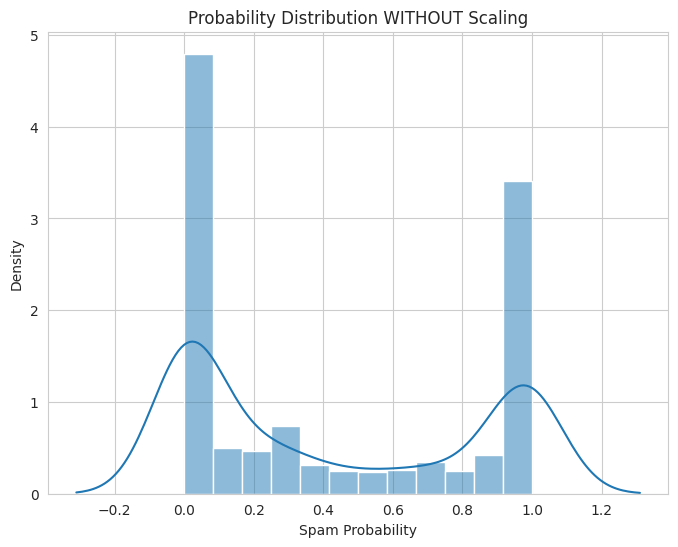

In [18]:
"""
Try all previous steps without data scaling
* Show how quality on test data changed
* Show how most valuable features changed
* Show how "spam" and "not spam" objects changed
* Show how probabilities distribution changed
"""
# Train the model without scaling with best hyperparameters
best_model_no_scaling = LogisticRegression(
    random_state=1,
    solver='liblinear',
    penalty='l2',
    C=10.0,
    class_weight='balanced',
    n_jobs=8
)
best_model_no_scaling.fit(x_dev, y_dev)

# Evaluate quality on test data (no scaling)
y_test_pred_ns = best_model_no_scaling.predict(x_test)
y_test_proba_ns = best_model_no_scaling.predict_proba(x_test)[:, 1]
# Calculate F1-score and AUC on the test data (without scaling)
from sklearn.metrics import f1_score, roc_auc_score
test_f1_ns = f1_score(y_test, y_test_pred_ns)
test_auc_ns = roc_auc_score(y_test, y_test_proba_ns)

print("=== Without Scaling: Test Quality ===")
print(f"Test AUC: {test_auc_ns:.5f}")
print(f"Test F1: {test_f1_ns:.5f}")
print()

# Analyze how most valuable features changed without scaling
coef_ns = best_model_no_scaling.coef_.flatten()
lr_coef_ns = pd.DataFrame({'feature': x_dev.columns, 'coef': coef_ns})
top_5_spam_ns = lr_coef_ns.sort_values('coef', ascending=False).head(5)
top_5_not_spam_ns = lr_coef_ns.sort_values('coef', ascending=True).head(5)

print("=== Without Scaling: Feature Importances ===")
print("Top 5 features predicting 'spam':")
print(top_5_spam_ns)
print("\nTop 5 features predicting 'not spam':")
print(top_5_not_spam_ns)
print()

# Rank test objects by predicted spam probability (no scaling)
test_df_ns = x_test.copy()
test_df_ns['is_spam'] = y_test
test_df_ns['spam_probability'] = y_test_proba_ns
most_spam_ns = test_df_ns.sort_values('spam_probability', ascending=False).head(10)
least_spam_ns = test_df_ns.sort_values('spam_probability', ascending=True).head(10)

print("=== Without Scaling: Ranked Test Objects ===")
print("Top 10 most likely 'spam' objects:")
print(most_spam_ns)
print("\nTop 10 least likely 'spam' objects:")
print(least_spam_ns)
print()

# Plot the probability distribution (no scaling)
plt.figure(figsize=(8, 6))
sns.histplot(y_test_proba_ns, kde=True, stat='density', kde_kws={"cut": 3})
plt.title("Probability Distribution WITHOUT Scaling")
plt.xlabel("Spam Probability")
plt.show()

=== Comparison Summary ===
Test Quality:
  WITH Scaling    -> Test AUC: 0.97197, Test F1: 0.91126
  WITHOUT Scaling -> Test AUC: 0.97266, Test F1: 0.91046

Feature Importance (Top 5 'spam') Comparison:
  WITH Scaling (previously):
                       feature      coef
3                 word_freq_3d  2.123234
55  capital_run_length_longest  2.008134
52                 char_freq_$  1.265894
6             word_freq_remove  1.020983
15              word_freq_free  0.949083

  WITHOUT Scaling:
             feature      coef
52       char_freq_$  4.982100
6   word_freq_remove  2.581559
22     word_freq_000  2.462936
19  word_freq_credit  1.491596
3       word_freq_3d  1.336813

Ranking Comparison (Top 10 most 'spam' objects):
  WITH Scaling (previously):
      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
275             0.00               0.00           0.00         19.16   
1033            1.24               0.00           0.82          0.00   
489             0.00  

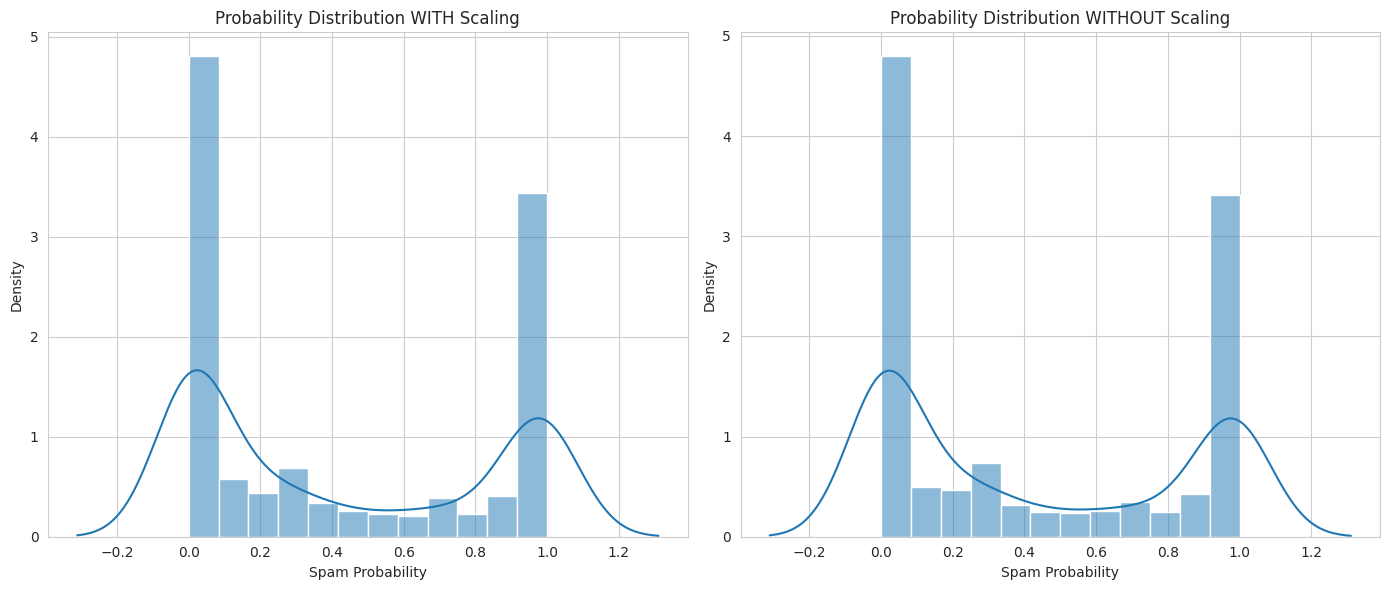

In [19]:
# Comparison with With-Scaling Results
print("=== Comparison Summary ===")
print("Test Quality:")
print(f"  WITH Scaling    -> Test AUC: {test_auc:.5f}, Test F1: {test_f1:.5f}")
print(f"  WITHOUT Scaling -> Test AUC: {test_auc_ns:.5f}, Test F1: {test_f1_ns:.5f}")
print()

print("Feature Importance (Top 5 'spam') Comparison:")
print("  WITH Scaling (previously):")
print(top_5_spam)
print("\n  WITHOUT Scaling:")
print(top_5_spam_ns)
print()

print("Ranking Comparison (Top 10 most 'spam' objects):")
print("  WITH Scaling (previously):")
print(most_spam)
print("\n  WITHOUT Scaling:")
print(most_spam_ns)
print()

# Side-by-side probability distribution plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_test_proba, kde=True, stat='density', kde_kws={"cut": 3})
plt.title("Probability Distribution WITH Scaling")
plt.xlabel("Spam Probability")

plt.subplot(1, 2, 2)
sns.histplot(y_test_proba_ns, kde=True, stat='density', kde_kws={"cut": 3})
plt.title("Probability Distribution WITHOUT Scaling")
plt.xlabel("Spam Probability")
plt.tight_layout()
plt.show()

---
### Perform GridSearchCV to train Naive Bayes classifier

In [20]:
# set data scaler
scaler = MinMaxScaler((0, 1))

# set classifier parameters
clf_params = {'alpha': np.linspace(0, 1, 10),
              'fit_prior': [True, False]}
clf = MultinomialNB()

# set scorer
scorer_ = 'f1'

# set CV parameters
cv = 5

# set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8,
                    verbose=1)

# set Pipeline parameters
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])

# launch pipeline with scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(x_dev.values, y_dev.values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Find the best NB parameters

In [21]:
print(f'NB classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

NB classifier gets best f1: 0.854742 with parameters: {'alpha': np.float64(0.1111111111111111), 'fit_prior': True}


### Look at GridSearchCV history

In [22]:
columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_result = pd.DataFrame(grcv.cv_results_).drop(columns_to_drop, axis=1)
grcv_result.head(10)

,param_alpha,param_fit_prior,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000000,True,0.574761,0.583065,0.577495,0.573840,0.583691,0.578570,0.004110,19,0.579494,0.577424,0.578807,0.579733,0.577270,0.578546,0.001026
1,0.000000,False,0.574761,0.583065,0.577495,0.573840,0.583691,0.578570,0.004110,19,0.579494,0.577424,0.578807,0.579733,0.577270,0.578546,0.001026
2,0.111111,True,0.847870,0.870079,0.876712,0.858847,0.820202,0.854742,0.019875,1,0.856154,0.848546,0.848120,0.858987,0.861111,0.854584,0.005342
3,0.111111,False,0.822400,0.841424,0.811232,0.832536,0.813291,0.824177,0.011459,10,0.824464,0.823857,0.829992,0.825410,0.831325,0.827010,0.003050
4,0.222222,True,0.840816,0.867850,0.876712,0.854871,0.813765,0.850803,0.022136,3,0.854599,0.847543,0.847695,0.857427,0.860546,0.853562,0.005205
5,0.222222,False,0.819777,0.836013,0.809969,0.831210,0.810726,0.821539,0.010554,11,0.822504,0.821896,0.828663,0.821798,0.828995,0.824771,0.003324
6,0.333333,True,0.840816,0.867850,0.876712,0.854871,0.813765,0.850803,0.022136,3,0.855022,0.847118,0.847118,0.855865,0.860546,0.853134,0.005260
7,0.333333,False,0.817170,0.836013,0.808709,0.824645,0.810726,0.819452,0.009980,12,0.820229,0.820269,0.827284,0.819659,0.825030,0.822494,0.003082
8,0.444444,True,0.842536,0.867850,0.878431,0.854871,0.811359,0.851009,0.023214,2,0.854879,0.847118,0.846540,0.854156,0.859274,0.852393,0.004873
9,0.444444,False,0.817170,0.834671,0.808709,0.824645,0.809449,0.818929,0.009776,13,0.817967,0.818469,0.825637,0.818362,0.825030,0.821093,0.003472


### Task 2 (2 points)

In [23]:
"""
Find 5 best parameters' combinations for trained GridSearchCV
Show Naive Bayes quality with these parameters
"""
# Extract and sort the GridSearchCV results
columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_result = pd.DataFrame(grcv.cv_results_).drop(columns_to_drop, axis=1)
# Sort by mean_test_score to find the best parameter combinations
sorted_results = grcv_result.sort_values('mean_test_score', ascending=False)
best_5_combinations = sorted_results.head(5)
print("Top 5 best parameter combinations based on mean_test_score:")
print(best_5_combinations)
print("\nEvaluating Naive Bayes quality for top 5 combinations:")

from sklearn.metrics import f1_score, roc_auc_score

for i, row in best_5_combinations.iterrows():
    # Set Naive Bayes parameters from the row
    nb_params = row['param_alpha'], row['param_fit_prior']
    alpha, fit_prior = nb_params
    # Train Naive Bayes using these parameters
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    nb_classifier.fit(x_dev.values, y_dev.values)
    # Predict and evaluate on the test data
    y_test_pred = nb_classifier.predict(x_test.values)
    y_test_proba = nb_classifier.predict_proba(x_test.values)[:, 1]
    test_f1 = f1_score(y_test.values, y_test_pred)
    test_auc = roc_auc_score(y_test.values, y_test_proba)
    print(f"Parameters: alpha={alpha}, fit_prior={fit_prior}")
    print(f"Test F1: {test_f1:.5f}, Test AUC: {test_auc:.5f}")


Top 5 best parameter combinations based on mean_test_score:
    param_alpha  param_fit_prior  split0_test_score  split1_test_score  \
2      0.111111             True           0.847870           0.870079   
8      0.444444             True           0.842536           0.867850   
4      0.222222             True           0.840816           0.867850   
6      0.333333             True           0.840816           0.867850   
10     0.555556             True           0.842536           0.867850   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
2            0.876712           0.858847           0.820202         0.854742   
8            0.878431           0.854871           0.811359         0.851009   
4            0.876712           0.854871           0.813765         0.850803   
6            0.876712           0.854871           0.813765         0.850803   
10           0.878431           0.852590           0.811359         0.850553   

    std_test_s

In [24]:
"""
Set scorer to roc_auc and repeat experiment
Find 5 best parameters' combinations and show NB quality with this parameters
"""
# Set the scorer to 'roc_auc'
scorer_ = 'roc_auc'
# Update GridSearchCV with the new scorer
grcv_auc = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True,
                        n_jobs=8, verbose=1)
# Launch pipeline with scaling followed by cross-validation with parameters tuning
pipeline_auc = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv_auc)])
_ = pipeline_auc.fit(x_dev.values, y_dev.values)
columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_auc_result = pd.DataFrame(grcv_auc.cv_results_).drop(columns_to_drop, axis=1)
# Sort by mean_test_score to find the best parameter combinations
sorted_results_auc = grcv_auc_result.sort_values('mean_test_score', ascending=False)
best_5_combinations_auc = sorted_results_auc.head(5)
print("Top 5 best parameter combinations based on mean_test_score (roc_auc):")
print(best_5_combinations_auc)

# Evaluate Naive Bayes quality with these parameters
print("\nEvaluating Naive Bayes quality for top 5 combinations:")
from sklearn.metrics import f1_score, roc_auc_score
for i, row in best_5_combinations_auc.iterrows():
    # Set Naive Bayes parameters from the row
    nb_params = row['param_alpha'], row['param_fit_prior']
    alpha, fit_prior = nb_params

    # Train Naive Bayes using these parameters
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    nb_classifier.fit(x_dev.values, y_dev.values)
    y_test_pred_auc = nb_classifier.predict(x_test.values)
    y_test_proba_auc = nb_classifier.predict_proba(x_test.values)[:, 1]

    test_f1_auc = f1_score(y_test.values, y_test_pred_auc)
    test_auc_auc = roc_auc_score(y_test.values, y_test_proba_auc)
    print(f"Parameters: alpha={alpha}, fit_prior={fit_prior}")
    print(f"Test F1: {test_f1_auc:.5f}, Test AUC: {test_auc_auc:.5f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Top 5 best parameter combinations based on mean_test_score (roc_auc):
   param_alpha  param_fit_prior  split0_test_score  split1_test_score  \
2     0.111111             True           0.960229           0.963974   
3     0.111111            False           0.960229           0.963974   
4     0.222222             True           0.960026           0.963631   
5     0.222222            False           0.960026           0.963631   
6     0.333333             True           0.959929           0.963358   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
2           0.959867           0.955522           0.943191         0.956556   
3           0.959867           0.955522           0.943191         0.956556   
4           0.959603           0.955082           0.942698         0.956208   
5           0.959603           0.955082           0.942698         0.956208   
6           0.959357           0.9

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.95655635 0.95655635 0.956208   0.956208
 0.95594411 0.95594411 0.95571188 0.95571188 0.95544803 0.95544803
 0.95521754 0.95521754 0.95506271 0.95506271 0.95492371 0.95492371
 0.95476363 0.95476363]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [       nan        nan 0.9579344  0.9579344  0.95754302 0.95754302
 0.957223   0.957223   0.95696006 0.95696006 0.95674034 0.95674034
 0.95651446 0.95651446 0.95632201 0.95632201 0.95615981 0.95615981
 0.95597758 0.95597758]
  warnings.warn(


In [25]:
"""
Create a custom scorer using make_scorer and repeat the experiment. Note: errors_score is an error metric
Show F1 and roc_auc values for 5 best and 5 worst parameters combinations
"""
#Define the custom error scorer
def errors_score(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)
custom_scorer = make_scorer(errors_score, greater_is_better=False)
# Set up GridSearchCV experiment with the custom scorer
scaler = MinMaxScaler((0, 1))
clf_params = {
    'alpha': np.linspace(0, 1, 10),
    'fit_prior': [True, False]
}
clf = MultinomialNB()
cv = 5
# Create GridSearchCV with the custom scorer
grcv_custom = GridSearchCV(
    estimator=clf,
    param_grid=clf_params,
    scoring=custom_scorer,
    cv=cv,
    return_train_score=True,
    n_jobs=8,
    verbose=1
)

# Build the pipeline, scaling then hyperparameter tuning
pipeline_custom = Pipeline(steps=[
    ('scaling', scaler),
    ('parameter_tuning', grcv_custom)
])
# Fit on the development data
pipeline_custom.fit(x_dev.values, y_dev.values)
# Extract and sort GridSearchCV results based on custom scorer
columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_custom_result = pd.DataFrame(grcv_custom.cv_results_).drop(columns_to_drop, axis=1)
sorted_results = grcv_custom_result.sort_values('mean_test_score', ascending=False)
# Get top 5 best and bottom 5 worst parameter combinations
best_5 = sorted_results.head(5)
worst_5 = sorted_results.tail(5)

print("Top 5 parameter combinations using custom scorer (errors_score):")
print(best_5)
print("\nWorst 5 parameter combinations using custom scorer (errors_score):")
print(worst_5)
print()

# Evaluate the top and worst parameter combinations on test data
x_dev_scaled = scaler.fit_transform(x_dev.values)
x_test_scaled = scaler.transform(x_test.values)
print("Evaluating F1 and ROC AUC for the 5 best parameter combinations:")
for i, row in best_5.iterrows():
    alpha_val = row['param_alpha']
    fit_prior_val = row['param_fit_prior']
    nb_model = MultinomialNB(alpha=alpha_val, fit_prior=fit_prior_val)
    nb_model.fit(x_dev_scaled, y_dev.values)

    y_pred_custom = nb_model.predict(x_test_scaled)
    y_proba_custom = nb_model.predict_proba(x_test_scaled)[:, 1]
    y_proba_custom = np.nan_to_num(y_proba_custom, nan=0.0)

    f1_val = f1_score(y_test.values, y_pred_custom)
    auc_val = roc_auc_score(y_test.values, y_proba_custom)
    print(f"Parameters: alpha = {alpha_val}, fit_prior = {fit_prior_val}")
    print(f"  F1 Score: {f1_val:.5f}, ROC AUC: {auc_val:.5f}\n")

print("Evaluating F1 and ROC AUC for the 5 worst parameter combinations:")
for i, row in worst_5.iterrows():
    alpha_val = row['param_alpha']
    fit_prior_val = row['param_fit_prior']
    nb_model = MultinomialNB(alpha=alpha_val, fit_prior=fit_prior_val)
    nb_model.fit(x_dev_scaled, y_dev.values)

    y_pred_custom = nb_model.predict(x_test_scaled)
    y_proba_custom = nb_model.predict_proba(x_test_scaled)[:, 1]
    y_proba_custom = np.nan_to_num(y_proba_custom, nan=0.0)

    f1_val = f1_score(y_test.values, y_pred_custom)
    auc_val = roc_auc_score(y_test.values, y_proba_custom)
    print(f"Parameters: alpha = {alpha_val}, fit_prior = {fit_prior_val}")
    print(f"  F1 Score: {f1_val:.5f}, ROC AUC: {auc_val:.5f}\n")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Top 5 parameter combinations using custom scorer (errors_score):
    param_alpha  param_fit_prior  split0_test_score  split1_test_score  \
2      0.111111             True          -0.108696          -0.095652   
8      0.444444             True          -0.111594          -0.097101   
4      0.222222             True          -0.113043          -0.097101   
10     0.555556             True          -0.111594          -0.097101   
6      0.333333             True          -0.113043          -0.097101   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
2           -0.091304          -0.102899          -0.128986        -0.105507   
8           -0.089855          -0.105797          -0.134783        -0.107826   
4           -0.091304          -0.105797          -0.133333        -0.108116   
10          -0.089855          -0.107246          -0.134783        -0.108116   
6           -0.091304       

/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [26]:
"""
Find 5 most valuable features for "spam" class and 5 for "not spam" class
Are these features the same as in LR?
"""
# Naive Bayes Section
best_nb = grcv_custom.best_estimator_

# Extract feature log probabilities for each class
coefficients = best_nb.feature_log_prob_
spam_coefficients = coefficients[1]
not_spam_coefficients = coefficients[0]

# Create a DataFrame to map features with their importance
nb_features_df = pd.DataFrame({
    'feature': x_dev.columns,
    'spam_coeff': spam_coefficients,
    'not_spam_coeff': not_spam_coefficients
})

# Find top 5 features for spam and not spam
top_5_spam_nb = nb_features_df.sort_values(by='spam_coeff', ascending=False).head(5)
top_5_not_spam_nb = nb_features_df.sort_values(by='not_spam_coeff').head(5)

print("Top 5 features for 'spam' (Naive Bayes):")
print(top_5_spam_nb[['feature', 'spam_coeff']])
print("\nTop 5 features for 'not spam' (Naive Bayes):")
print(top_5_not_spam_nb[['feature', 'not_spam_coeff']])


# Logistic Regression
best_lr = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, random_state=1)
best_lr.fit(x_dev.values, y_dev.values)

# Extract coefficients for Logistic Regression
lr_features_df = pd.DataFrame({'feature': x_dev.columns, 'coef': best_lr.coef_.flatten()})

# Find top 5 features for spam and not spam
top_5_spam_lr = lr_features_df.sort_values(by='coef', ascending=False).head(5)
top_5_not_spam_lr = lr_features_df.sort_values(by='coef').head(5)

print("\nTop 5 features for 'spam' (Logistic Regression):")
print(top_5_spam_lr[['feature', 'coef']])
print("\nTop 5 features for 'not spam' (Logistic Regression):")
print(top_5_not_spam_lr[['feature', 'coef']])


Top 5 features for 'spam' (Naive Bayes):
           feature  spam_coeff
20  word_freq_your   -2.194081
18   word_freq_you   -2.228794
2    word_freq_all   -2.663827
11  word_freq_will   -2.768689
4    word_freq_our   -3.056562

Top 5 features for 'not spam' (Naive Bayes):
             feature  not_spam_coeff
3       word_freq_3d       -9.242944
19  word_freq_credit       -6.692303
22     word_freq_000       -6.538123
23   word_freq_money       -6.515575
53       char_freq_#       -6.483085

Top 5 features for 'spam' (Logistic Regression):
             feature      coef
52       char_freq_$  3.213922
6   word_freq_remove  2.441210
22     word_freq_000  2.274548
19  word_freq_credit  1.065619
15    word_freq_free  0.976381

Top 5 features for 'not spam' (Logistic Regression):
              feature      coef
26   word_freq_george -3.289884
45      word_freq_edu -2.177652
41  word_freq_meeting -1.726576
24       word_freq_hp -1.611494
43  word_freq_project -1.372302


The features identified by Naive Bayes (NB) are **not necessarily the same** as those identified by Logistic Regression (LR), although there is some overlap.

#### Differences Between NB and LR Features:
1. **Statistical Approach:**
   - **Naive Bayes:** Ranks features based on their conditional probabilities in each class (e.g., "spam" and "not spam"). It highlights features that are frequent in one class but rare in the other.
   - **Logistic Regression:** Ranks features based on their contribution to the decision boundary using coefficients that represent changes in log odds.

2. **Key Examples of Differences:**
   - **Spam Class:**
     - **Naive Bayes:** Highlights features like `word_freq_your` and `word_freq_you`.
     - **Logistic Regression:** Emphasizes `char_freq_$` and `word_freq_remove`.
   - **Not Spam Class:**
     - **Naive Bayes:** Prioritizes `word_freq_3d` and `word_freq_credit`.
     - **Logistic Regression:** Highlights `word_freq_george` and `word_freq_edu`.

3. **Assumptions:**
   - **Naive Bayes:** Assumes feature independence, which impacts its rankings.
   - **Logistic Regression:** Accounts for feature interactions, leading to different rankings.

#### Conclusion:
While some features, like `word_freq_000` for spam and `word_freq_george` for not spam, are shared between NB and LR, the complete rankings and selected features differ due to the models' distinct methodologies and assumptions. These differences provide complementary insights into feature importance.


### Find the best scaler and parameters for k-Nearest Neighbors classifier

In [27]:
# set classifier parameters
clf_params = {'n_neighbors': list(range(1, 6)),
              'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)

# set scorer
scorer_ = 'roc_auc'

# set CV parameters
cv = 5

# set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8,
                    verbose=1)

# set scaler as Pipeline parameter
scaler = Normalizer()

# set Pipeline parameters
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])

# launch the pipeline with scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(x_dev.values, y_dev.values)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Find best kNN parameters

In [28]:
print(f'kNN classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

kNN classifier gets best roc_auc: 0.915130 with parameters: {'n_neighbors': 4, 'p': 1}


### Task 3 (2 points)

In [29]:
"""
Try to obtain the best kNN quality using GridSearchCV with different scalers
Print scaler, parameters and obtained quality
"""
# Set classifier parameters
clf_params = {'n_neighbors': list(range(1, 6)),
              'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)
# Set scorer and CV parameters
scorer_ = 'roc_auc'
cv = 5
# List of scalers to test
scalers = [
    ("StandardScaler", StandardScaler()),
    ("Normalizer", Normalizer()),
    ("MinMaxScaler", MinMaxScaler(feature_range=(0, 1)))
]
# Loop over each scaler, setting up a pipeline and finding best parameters
for scaler_name, scaler in scalers:
    grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv,
                        return_train_score=True, n_jobs=8, verbose=1)
    pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])
    pipeline.fit(x_dev.values, y_dev.values)
    best_score = grcv.best_score_
    best_params = grcv.best_params_
    print(f"{scaler_name}: best {scorer_} = {best_score:.6f} with parameters: {best_params}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
StandardScaler: best roc_auc = 0.953987 with parameters: {'n_neighbors': 5, 'p': 1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Normalizer: best roc_auc = 0.915130 with parameters: {'n_neighbors': 4, 'p': 1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MinMaxScaler: best roc_auc = 0.946019 with parameters: {'n_neighbors': 5, 'p': 1}


In [30]:
"""
Show how kNN quality changes without scaling before training
"""
# Define parameters, classifier, and scoring
clf_params = {'n_neighbors': list(range(1, 6)),
              'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)
scorer_ = 'roc_auc'
cv = 5

# Set up GridSearchCV without any scaling
grcv_no_scaling = GridSearchCV(estimator=clf,
                               param_grid=clf_params,
                               scoring=scorer_,
                               cv=cv,
                               return_train_score=True,
                               n_jobs=8,
                               verbose=1)

# Fit directly on raw (unscaled) data
grcv_no_scaling.fit(x_dev.values, y_dev.values)

print("Without Scaling:")
print(f"kNN classifier gets best {scorer_}: {grcv_no_scaling.best_score_:.6f} with parameters: {grcv_no_scaling.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Without Scaling:
kNN classifier gets best roc_auc: 0.893929 with parameters: {'n_neighbors': 5, 'p': 1}


### Task 4 (3 points)

In [31]:
"""
Take the best LR, NB and kNN classifiers according to roc_auc on cross-validation.
Compare their quality on the test data.
Which classifier has the best roc_auc score? What are its parameters?
Which classifier has the least false negatives?
Which classifier has the least type-1 errors?
"""
# Helper Function to Evaluate a Model
def evaluate_model(model, X, y):
    y_proba = model.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, y_proba)
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return roc_auc, fn, fp

roc_auc_lr, fn_lr, fp_lr = evaluate_model(best_lr, x_test.values, y_test.values)
roc_auc_nb, fn_nb, fp_nb = evaluate_model(best_nb, x_test.values, y_test.values)

clf_params = {'n_neighbors': list(range(1, 6)),
              'p': list(range(1, 3))}
scorer_ = 'roc_auc'
cv = 5

# Build the kNN pipeline using StandardScaler
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('grcv', GridSearchCV(
        estimator=KNeighborsClassifier(n_jobs=1),
        param_grid=clf_params,
        scoring=scorer_,
        cv=cv,
        return_train_score=True,
        n_jobs=8,
        verbose=1))
])
pipeline_knn.fit(x_dev.values, y_dev.values)
roc_auc_knn, fn_knn, fp_knn = evaluate_model(pipeline_knn, x_test.values, y_test.values)

print("Test Data Evaluation:")
print("Logistic Regression: roc_auc = {:.6f}, false negatives = {}, false positives = {}".format(roc_auc_lr, fn_lr, fp_lr))
print("Naive Bayes       : roc_auc = {:.6f}, false negatives = {}, false positives = {}".format(roc_auc_nb, fn_nb, fp_nb))
print("kNN               : roc_auc = {:.6f}, false negatives = {}, false positives = {}".format(roc_auc_knn, fn_knn, fp_knn))

# Compare the Classifiers
# Determine which classifier has the best roc_auc score
if roc_auc_lr >= roc_auc_nb and roc_auc_lr >= roc_auc_knn:
    best_roc_model = "Logistic Regression"
    best_params = best_lr.get_params()
elif roc_auc_nb >= roc_auc_lr and roc_auc_nb >= roc_auc_knn:
    best_roc_model = "Naive Bayes"
    best_params = best_nb.get_params()
else:
    best_roc_model = "kNN"
    best_params = pipeline_knn.named_steps['grcv'].best_params_

# Determine which classifier has the least false negatives
if fn_lr <= fn_nb and fn_lr <= fn_knn:
    least_fn_model = "Logistic Regression"
elif fn_nb <= fn_lr and fn_nb <= fn_knn:
    least_fn_model = "Naive Bayes"
else:
    least_fn_model = "kNN"

# Determine which classifier has the least false positive
if fp_lr <= fp_nb and fp_lr <= fp_knn:
    least_fp_model = "Logistic Regression"
elif fp_nb <= fp_lr and fp_nb <= fp_knn:
    least_fp_model = "Naive Bayes"
else:
    least_fp_model = "kNN"

print("\nComparison Results on Test Data:")
print("Classifier with best roc_auc score:", best_roc_model)
print("Parameters of the best roc_auc classifier:", best_params)
print("Classifier with the least false negatives:", least_fn_model)
print("Classifier with the least type-1 errors (false positives):", least_fp_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Test Data Evaluation:
Logistic Regression: roc_auc = 0.972222, false negatives = 41, false positives = 32
Naive Bayes       : roc_auc = 0.686686, false negatives = 0, false positives = 604
kNN               : roc_auc = 0.964029, false negatives = 65, false positives = 32

Comparison Results on Test Data:
Classifier with best roc_auc score: Logistic Regression
Parameters of the best roc_auc classifier: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Classifier with the least false negatives: Naive Bayes
Classifier with the least type-1 errors (false positives): Logistic Regression


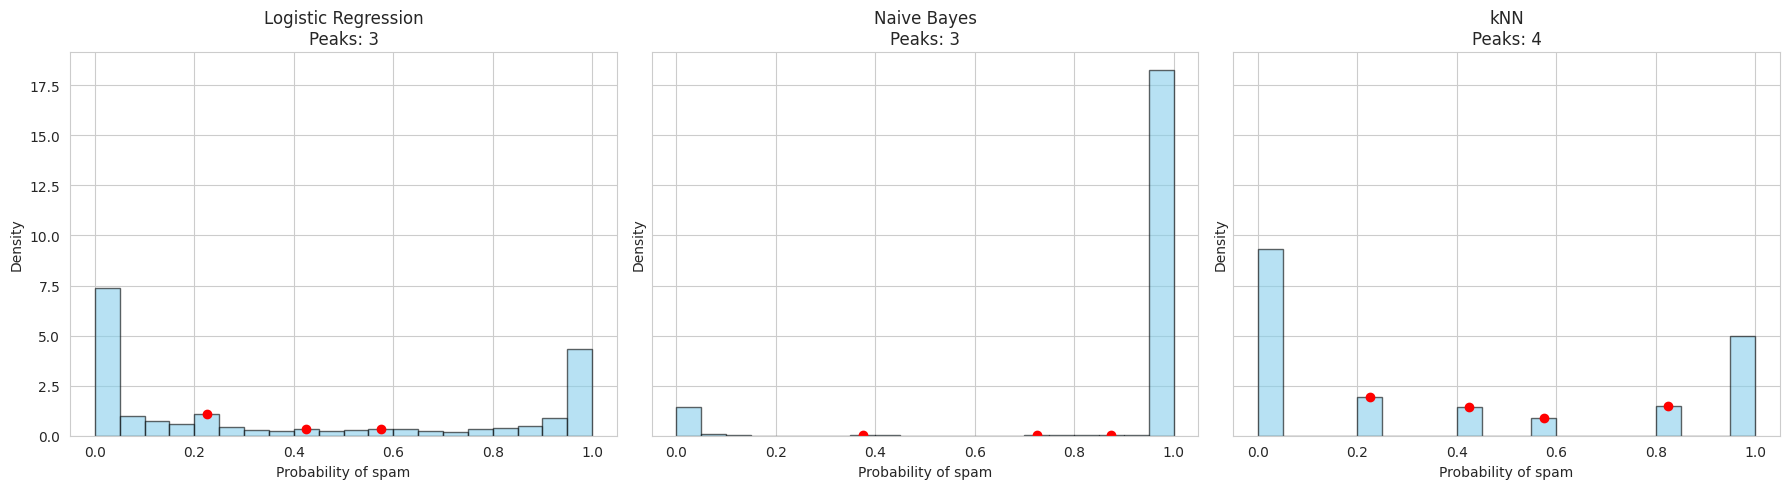

In [32]:
"""
Plot probabilities for the test data of being from "spam" class
How many modes (or ``peaks``) these distributions have?
"""
from scipy.signal import find_peaks
# Get predicted probabilities for the "spam" class for each classifier
probs_lr = best_lr.predict_proba(x_test.values)[:, 1]
probs_nb = best_nb.predict_proba(x_test.values)[:, 1]
probs_knn = pipeline_knn.predict_proba(x_test.values)[:, 1]
models = [("Logistic Regression", probs_lr),
          ("Naive Bayes", probs_nb),
          ("kNN", probs_knn)]

# Create subplots to compare the distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (model_name, probs) in zip(axes, models):
    counts, bins, _ = ax.hist(probs, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    # Compute bin centers for peak detection
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Find peaks in the histogram data
    peaks, _ = find_peaks(counts)
    num_peaks = len(peaks)
    ax.plot(bin_centers[peaks], counts[peaks], "ro")
    ax.set_title(f"{model_name}\nPeaks: {num_peaks}")
    ax.set_xlabel("Probability of spam")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

In [33]:
"""
Show which classifier is the most overfitted according to development set (union of training and validation sets) and test set
Show which classifier is the least overfitted according to development set (union of training and validation sets) and test set
"""
# Get dev set predictions for all 3 classifiers
probs_dev_lr = best_lr.predict_proba(x_dev.values)[:, 1]
probs_dev_nb = best_nb.predict_proba(x_dev.values)[:, 1]
probs_dev_knn = pipeline_knn.predict_proba(x_dev.values)[:, 1]

# Get test set predictions
probs_test_lr = best_lr.predict_proba(x_test.values)[:, 1]
probs_test_nb = best_nb.predict_proba(x_test.values)[:, 1]
probs_test_knn = pipeline_knn.predict_proba(x_test.values)[:, 1]

# Calculate AUC scores for dev and test sets
auc_dev_lr = roc_auc_score(y_dev.values, probs_dev_lr)
auc_test_lr = roc_auc_score(y_test.values, probs_test_lr)
auc_dev_nb = roc_auc_score(y_dev.values, probs_dev_nb)
auc_test_nb = roc_auc_score(y_test.values, probs_test_nb)
auc_dev_knn = roc_auc_score(y_dev.values, probs_dev_knn)
auc_test_knn = roc_auc_score(y_test.values, probs_test_knn)

# Calculate overfitting gap: AUC(dev) - AUC(test)
overfit_gap_lr = auc_dev_lr - auc_test_lr
overfit_gap_nb = auc_dev_nb - auc_test_nb
overfit_gap_knn = auc_dev_knn - auc_test_knn

print("Overfitting Analysis (AUC gap = dev - test):")
print(f"Logistic Regression: AUC(dev) = {auc_dev_lr:.5f}, AUC(test) = {auc_test_lr:.5f}, Gap = {overfit_gap_lr:.5f}")
print(f"Naive Bayes        : AUC(dev) = {auc_dev_nb:.5f}, AUC(test) = {auc_test_nb:.5f}, Gap = {overfit_gap_nb:.5f}")
print(f"kNN                : AUC(dev) = {auc_dev_knn:.5f}, AUC(test) = {auc_test_knn:.5f}, Gap = {overfit_gap_knn:.5f}")

# Identify the most and least overfitted classifier
gaps = {
    "Logistic Regression": overfit_gap_lr,
    "Naive Bayes": overfit_gap_nb,
    "kNN": overfit_gap_knn
}

most_overfitted = max(gaps, key=gaps.get)
least_overfitted = min(gaps, key=gaps.get)

print("\nMost overfitted classifier:", most_overfitted)
print("Least overfitted classifier:", least_overfitted)

Overfitting Analysis (AUC gap = dev - test):
Logistic Regression: AUC(dev) = 0.97581, AUC(test) = 0.97222, Gap = 0.00358
Naive Bayes        : AUC(dev) = 0.69430, AUC(test) = 0.68669, Gap = 0.00762
kNN                : AUC(dev) = 0.98750, AUC(test) = 0.96403, Gap = 0.02347

Most overfitted classifier: kNN
Least overfitted classifier: Logistic Regression


In [34]:
"""
Find 5 most and 5 least "spam" objects from the test data for every classifier.
Show which of them are matched and aren't matched.
"""
def show_spam_objects(model, model_name, x_test, y_test, threshold=0.5):
    # Get probabilities and predictions
    probs = model.predict_proba(x_test.values)[:, 1]
    preds = (probs >= threshold).astype(int)

    # Construct DataFrame
    df = pd.DataFrame({
        'Probability': probs,
        'Predicted': preds,
        'Actual': y_test.values
    }, index=x_test.index)

    # Get top 5 most and least spam-like objects
    most_spam = df.sort_values('Probability', ascending=False).head(5).copy()
    least_spam = df.sort_values('Probability', ascending=True).head(5).copy()
    most_spam['Matched'] = most_spam['Predicted'] == most_spam['Actual']
    least_spam['Matched'] = least_spam['Predicted'] == least_spam['Actual']

    # Store indices for comparison later
    top_indices = set(most_spam.index)
    bottom_indices = set(least_spam.index)

    print(f"🔍 Classifier: {model_name}")
    print("Top 5 Most Spam-Like Predictions:")
    display(most_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))

    print("Top 5 Least Spam-Like Predictions:")
    display(least_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))
    print("---------------------------------------------------\n")

    return top_indices, bottom_indices

# Run the function for each classifier
top_lr, bottom_lr = show_spam_objects(best_lr, "Logistic Regression", x_test, y_test)
top_nb, bottom_nb = show_spam_objects(best_nb, "Naive Bayes", x_test, y_test)
top_knn, bottom_knn = show_spam_objects(pipeline_knn, "kNN", x_test, y_test)

# Compare which indices are matched across classifiers (for both top and bottom predictions)
matched_top = top_lr & top_nb & top_knn
matched_bottom = bottom_lr & bottom_nb & bottom_knn

# Non-matched objects are those that appear in at least one classifier's top (or bottom) but not in all
not_matched_top = (top_lr | top_nb | top_knn) - matched_top
not_matched_bottom = (bottom_lr | bottom_nb | bottom_knn) - matched_bottom

print(" Indices matched in Top 5 most spam across all classifiers:", matched_top)
print("Indices NOT matched in Top 5 (disagreement):", not_matched_top)
print("Indices matched in Bottom 5 least spam across all classifiers:", matched_bottom)
print("Indices NOT matched in Bottom 5 (disagreement):", not_matched_bottom)

🔍 Classifier: Logistic Regression
Top 5 Most Spam-Like Predictions:


<ipython-input-34-718c0c413323>:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(most_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
1033,1.000000,1,1,True
275,1.000000,1,1,True
695,1.000000,1,1,True
424,1.000000,1,1,True
252,1.000000,1,1,True


Top 5 Least Spam-Like Predictions:


<ipython-input-34-718c0c413323>:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(least_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
592,0.000000,0,0,True
1075,0.000000,0,0,True
933,0.000000,0,0,True
1104,0.000000,0,0,True
1056,0.000000,0,0,True


---------------------------------------------------

🔍 Classifier: Naive Bayes
Top 5 Most Spam-Like Predictions:


<ipython-input-34-718c0c413323>:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(most_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
1149,1.000000,1,1,True
1148,1.000000,1,0,False
1,1.000000,1,0,False
2,1.000000,1,0,False
3,1.000000,1,1,True


Top 5 Least Spam-Like Predictions:


<ipython-input-34-718c0c413323>:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(least_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
1075,0.000000,0,0,True
592,0.000000,0,0,True
856,0.000000,0,0,True
933,0.000000,0,0,True
1056,0.000000,0,0,True


---------------------------------------------------

🔍 Classifier: kNN
Top 5 Most Spam-Like Predictions:


<ipython-input-34-718c0c413323>:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(most_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
3,1.000000,1,1,True
15,1.000000,1,1,True
4,1.000000,1,1,True
21,1.000000,1,1,True
417,1.000000,1,1,True


Top 5 Least Spam-Like Predictions:


<ipython-input-34-718c0c413323>:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(least_spam.style.applymap(lambda x: 'background-color: lightgreen' if x else 'background-color: salmon', subset=['Matched']))


,Probability,Predicted,Actual,Matched
32,0.000000,0,0,True
31,0.000000,0,0,True
29,0.000000,0,0,True
8,0.000000,0,0,True
6,0.000000,0,0,True


---------------------------------------------------

 Indices matched in Top 5 most spam across all classifiers: set()
Indices NOT matched in Top 5 (disagreement): {1, 2, 3, 417, 4, 424, 1033, 15, 1148, 275, 21, 695, 252, 1149}
Indices matched in Bottom 5 least spam across all classifiers: set()
Indices NOT matched in Bottom 5 (disagreement): {1056, 32, 933, 6, 8, 592, 1104, 1075, 856, 29, 31}


According to Andrew Ng's book: https://github.com/yennlh/ml-yearning/blob/master/Ng_MLY01_13.pdf

We usually define:

• Training set​ — Which you run your learning algorithm on.

• Dev (development) set​ — Which you use to tune parameters, select features, and make other decisions regarding the learning algorithm. Sometimes also called the hold-out cross validation set​.

• Test set​ — which you use to evaluate the performance of the algorithm, but not to make any decisions regarding what learning algorithm or parameters to use.